### Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

### Reading & preprocessing data

In [2]:
df = pd.read_csv("df_cleaned.csv")
df.head()

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1


In [3]:
X = df.drop("loan_status", axis = 1)
y = df["loan_status"]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=737)

### Decision Tree Model

In [5]:
def decision_tree_model(x_train, y_train, criterion="gini", max_depth=5, max_features=0.8,
                        max_leaf_nodes=None, min_samples_leaf=7, min_samples_split=3,
                        min_weight_fraction_leaf=0):
  """
  Creates & trains a Decision Tree Classifier on given training data.

  Args:
  ----------
  x_train : array-like or pandas DataFrame
      Training input samples.
  y_train : array-like
      Target values (class labels) corresponding to x_train.
  criterion : str, default="gini"
      The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity
      and "entropy" for the information gain.
  max_depth : int, default=5
      The maximum depth of the tree. If None, nodes are expanded until all leaves are pure.
  max_features : int, float, or {"sqrt", "log2"}, default=0.8
      The number of features to consider when looking for the best split.
      If float, it represents a fraction of the total number of features.
  max_leaf_nodes : int, default=None
      Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.
      If None, then unlimited number of leaf nodes.
  min_samples_leaf : int, default=7
      The minimum number of samples required to be at a leaf node.
  min_samples_split : int, default=3
      The minimum number of samples required to split an internal node.
  min_weight_fraction_leaf : float, default=0
      The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.

  Returns:
  -------
  dt : DecisionTreeClassifier
      The trained Decision Tree Classifier model.
  """
  dt = tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth,
                                   max_features = max_features, max_leaf_nodes = max_leaf_nodes,
                                   min_samples_leaf = min_samples_leaf,
                                   min_samples_split = min_samples_split,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf)
  dt.fit(x_train, y_train)
  return dt

In [6]:
dt = decision_tree_model(x_train, y_train)

In [7]:
y_pred_dt = dt.predict(x_test)

### Performance Measures

In [8]:
accuracy_score(y_test, y_pred_dt)

0.9530136641797301

In [9]:
f1_score(y_test, y_pred_dt)

0.9559338024293408

In [10]:
roc_auc_score(y_test, dt.predict_proba(x_test)[:, 1])

np.float64(0.9847034160558124)

### Interpretability

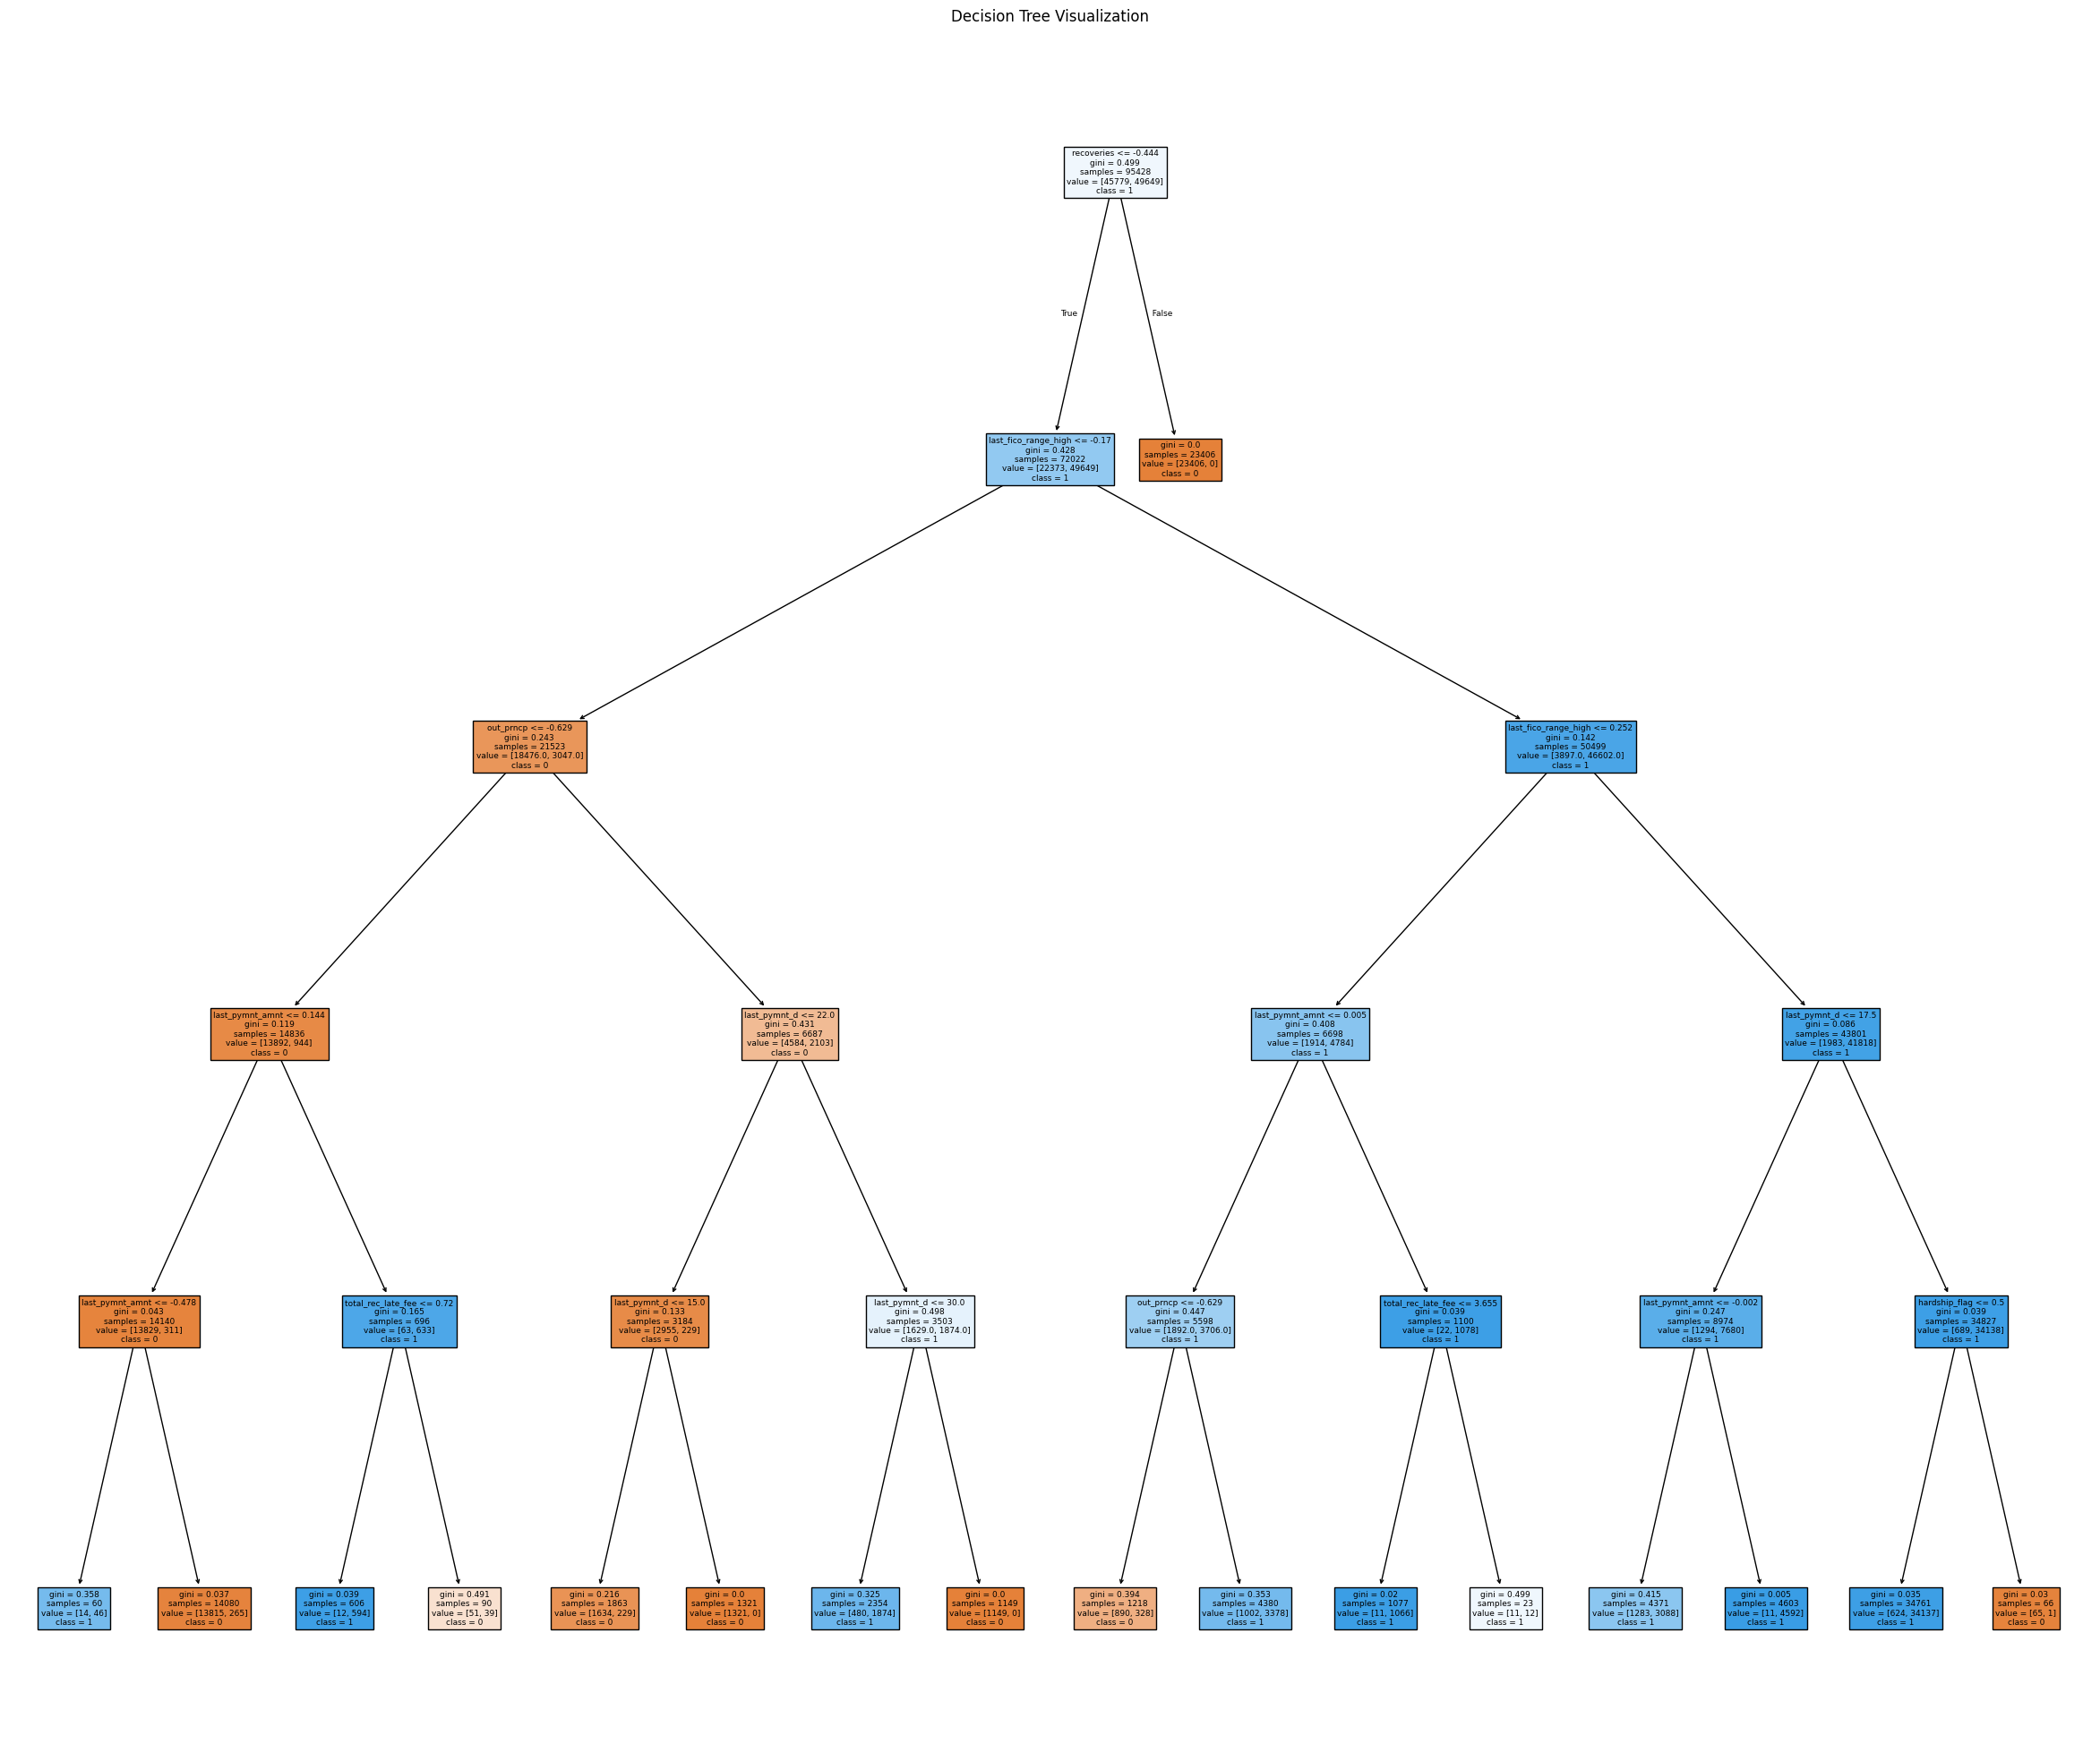

In [11]:
plt.figure(figsize=(30, 25))
plot_tree(dt, feature_names=X.columns, class_names=["0", "1"], filled=True)
plt.title('Decision Tree Visualization')
plt.show()